<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter5/5_3_PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GPUの確認
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6cb831dd-3d87-31bf-04c0-98a830feda11)


# PixelCNN

In [ ]:
#@title install packages (hide)
# !pip install -U tensorflow
# !pip install -U tensorflow-probabilty
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [ ]:
#@title import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers

# warningを非表示にする
tf.autograph.set_verbosity(0)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

sns.reset_defaults()
sns.set_context(context='talk', font_scale=1.0)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## モデルの特徴

### ピクセル値の確率分布

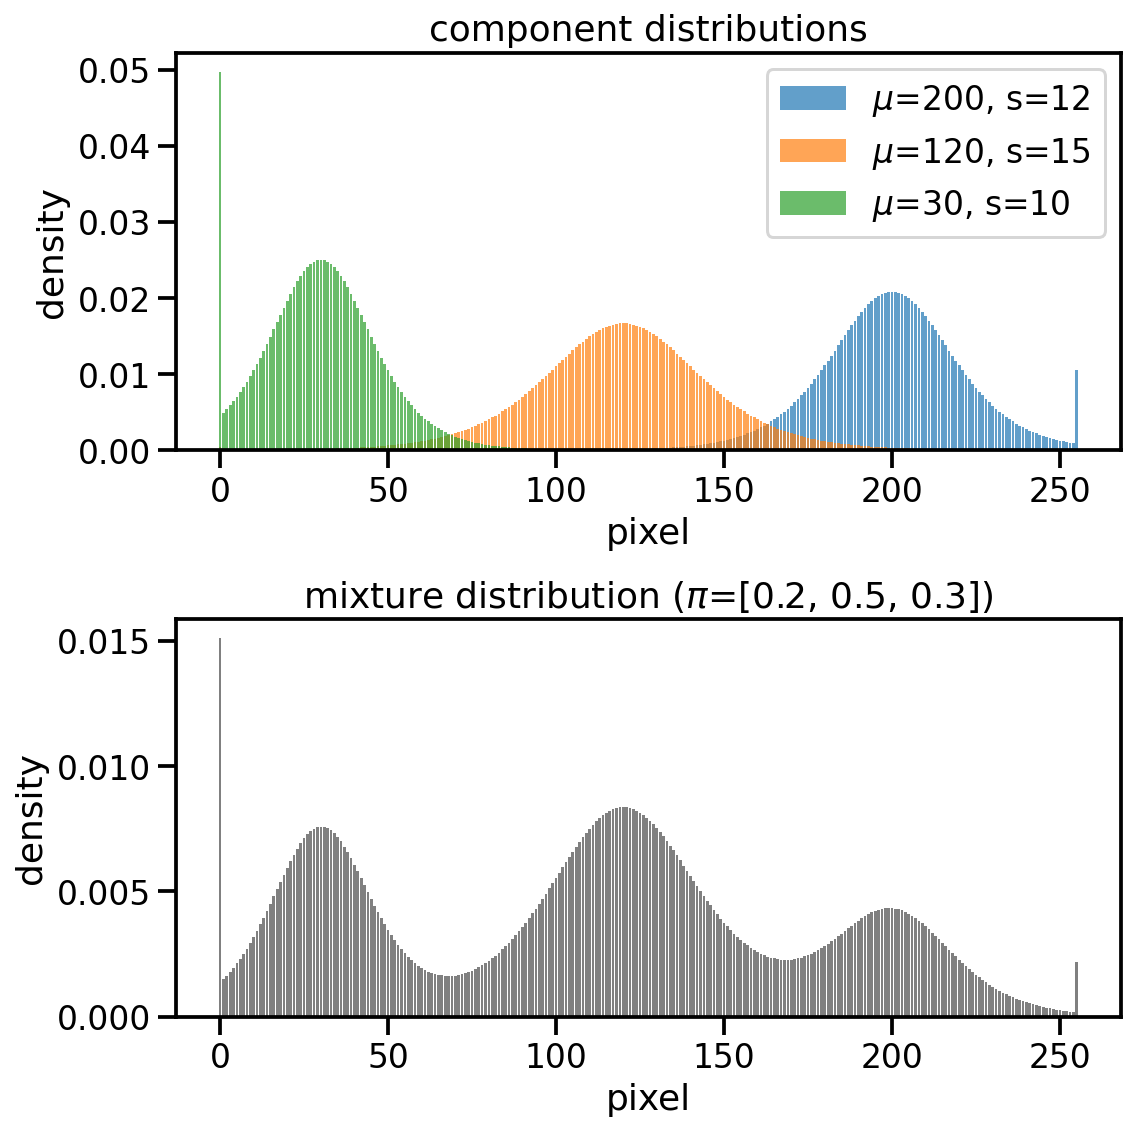

In [ ]:
#@title distribution of pixels
def trancated_logistic(x, mu, s):
  if 0 < x < 255:
    return tf.sigmoid((x + 0.5 - mu) / s) - tf.sigmoid((x - 0.5 - mu) / s)
  elif x == 0:
    return tf.sigmoid((x + 0.5 - mu) / s)
  elif x == 255:
    return 1 - tf.sigmoid((x - 0.5 - mu) / s)
  else:
    return 0
    

trancated_logistic = np.vectorize(trancated_logistic)

xx = np.arange(0, 256)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

mu_list, s_list = [200, 120, 30], [12, 15, 10]
ax = axes[0]
for mu, s in zip(mu_list, s_list):
    ax.bar(xx, trancated_logistic(xx, mu, s), label=f'$\mu$={mu}, s={s}', alpha=0.7)
ax.legend()
ax.set_xlabel('pixel')
ax.set_ylabel('density')
ax.set_title('component distributions')

pi_list = [0.2, 0.5, 0.3]
d = 0
for mu, s, pi in zip(mu_list, s_list, pi_list):
    d += pi * trancated_logistic(xx, mu, s)
ax = axes[1]
ax.bar(xx, d, color='gray')
ax.set_xlabel('pixel')
ax.set_ylabel('density')
ax.set_title(f'mixture distribution ($\pi$={pi_list})')

plt.tight_layout()

## TFPによる実装



In [ ]:
tf.random.set_seed(42)

# tensorflow_datasetsからMNISTのデータを読み込み
data = tfds.load('mnist')
train_data, test_data = data['train'], data['test']

def image_preprocess(x):
  x['image'] = tf.cast(x['image'], tf.float32)
  return ((x['image'], x['label']),)

batch_size = 16
train_it = train_data.map(image_preprocess).batch(batch_size).shuffle(1000)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
image_shape = (28, 28, 1)
# PixelCNNを定義
label_shape = ()
dist = tfd.PixelCNN(
    image_shape=image_shape,
    conditional_shape=label_shape,
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=5,
    dropout_p=.3,
)

# 入力の定義
image_input = tfkl.Input(shape=image_shape)
label_input = tfkl.Input(shape=label_shape)

# 対数尤度
log_prob = dist.log_prob(image_input, conditional_input=label_input)

# モデルの定義
class_cond_model = tfk.Model(
    inputs=[image_input, label_input], outputs=log_prob)
class_cond_model.add_loss(-tf.reduce_mean(log_prob))

# モデルのコンパイル
class_cond_model.compile(
    optimizer=tfk.optimizers.Adam(),
    metrics=[])

In [ ]:
%%time
# 学習（colaboratoryでの実行の場合、30分ほどかかるので注意）
class_cond_model.fit(train_it, epochs=10, verbose=True)

Epoch 1/10
3750/3750 [==============================] - 177s 40ms/step - loss: 651.4815
Epoch 2/10
3750/3750 [==============================] - 146s 39ms/step - loss: 606.0287
Epoch 3/10
3750/3750 [==============================] - 147s 39ms/step - loss: 596.1172
Epoch 4/10
3750/3750 [==============================] - 147s 39ms/step - loss: 589.5284
Epoch 5/10
3750/3750 [==============================] - 147s 39ms/step - loss: 584.0732
Epoch 6/10
3750/3750 [==============================] - 147s 39ms/step - loss: 577.9615
Epoch 7/10
3750/3750 [==============================] - 147s 39ms/step - loss: 572.9644
Epoch 8/10
3750/3750 [==============================] - 147s 39ms/step - loss: 568.4449
Epoch 9/10
3750/3750 [==============================] - 146s 39ms/step - loss: 564.2282
Epoch 10/10
3750/3750 [==============================] - 153s 41ms/step - loss: 561.0256
CPU times: user 31min, sys: 2min 7s, total: 33min 8s
Wall time: 29min 23s


In [ ]:
%%time
n_sample = 4
samples = dist.sample((n_sample, 3), conditional_input=[1., 2., 3.])

CPU times: user 1min 22s, sys: 3.17 s, total: 1min 25s
Wall time: 1min 17s


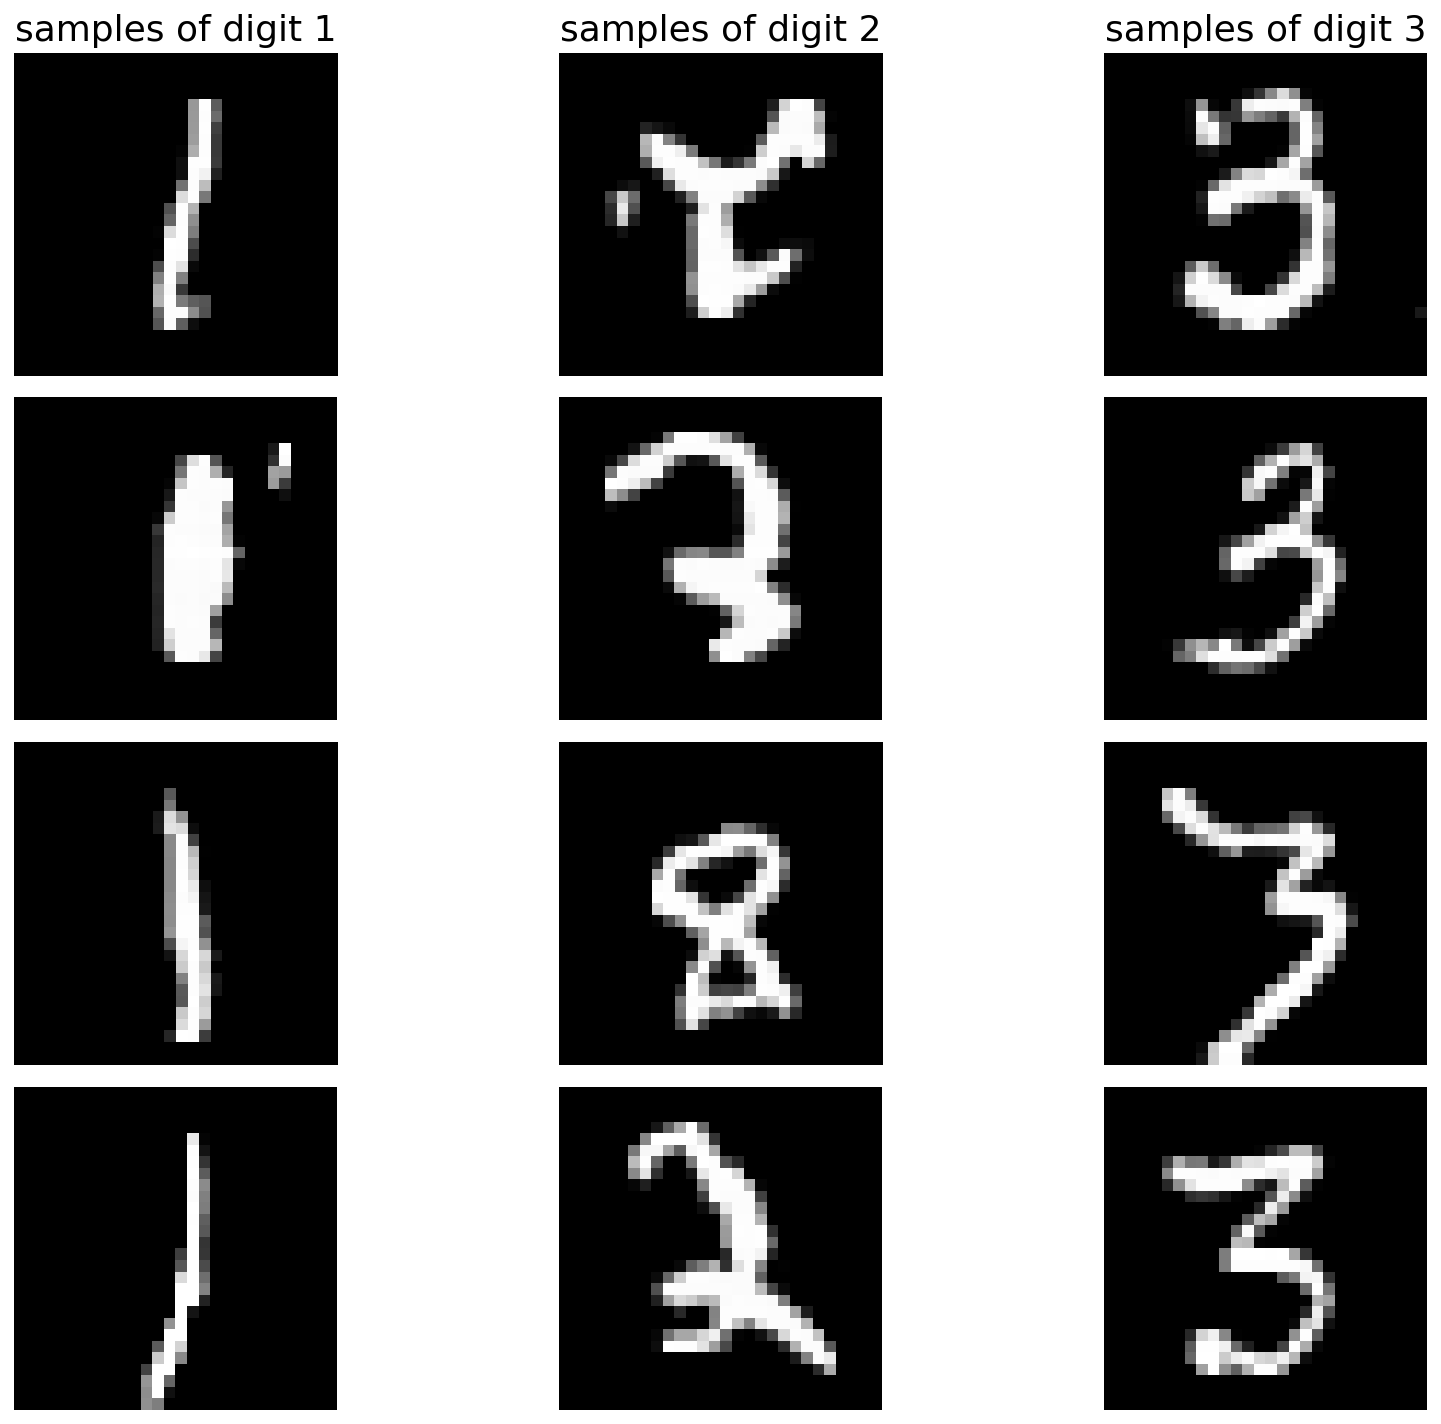

In [ ]:
fig, axes = plt.subplots(n_sample, 3, figsize=(12, 10))
for i in range(n_sample):
    for j in range(3):
        ax = axes[i][j]
        ax.imshow(samples[i, j, ..., 0], cmap='gray')
        if i == 0:
            ax.set_title(f'samples of digit {j+1}')
        ax.axis('off')
plt.tight_layout()

In [ ]:
%load_ext watermark
%watermark --iversions

IPython               : 5.5.0
numpy                 : 1.21.6
seaborn               : 0.11.2
matplotlib            : 3.2.2
keras                 : 2.8.0
tensorflow_probability: 0.16.0
tensorflow            : 2.8.0+zzzcolab20220506162203
tensorflow_datasets   : 4.0.1

